# 二値分類

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchviz import make_dot
import japanize_matplotlib
import torch.optim as optim
import pandas as pd
import sklearn
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 以下可視性のために定義。
import inspect
from IPython.display import display

# 引数の変数名を出力する変数。ただし仕様上、関数を呼び出した場所と同スコープの変数なら1。その一個上なら2，さらにひとつ上なら3にしなければならない。
def print_var_name(var,n=1):
    """
    受け取った変数の変数名を出力する関数
    """
    # 現在のフレームを取得する
    current_frame = inspect.currentframe()
    # 現在のフレームのn回外側のフレームを取得する
    outer_frame = current_frame
    for _ in range(n):
        outer_frame =outer_frame.f_back
    # 外側のフレームのローカル変数を取得する。2次元タプル?がずらっと配列で並んでいる。
    locals_dict = outer_frame.f_locals
    # 変数名を取得する
    var_name = [k for k, v in locals_dict.items() if v is var]
    if not var_name:
        print("変数が見つかりませんでした。")
    else:
        # 変数名を出力する
        print("変数名 : ",var_name[0]," 変数型は ",type(var))

def dataframe_converter(func):
    def wrapper(*args, **kwargs):
        for arg in args:
            try:
                # 引数がNumPy配列の場合はPandasデータフレームに変換する
                print_var_name(arg,2)
                if isinstance(arg, np.ndarray):
                    df = pd.DataFrame(arg)
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                elif isinstance(arg, torch.Tensor):
                    df = pd.DataFrame(arg.detach().numpy())
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                elif isinstance(arg, sklearn.utils.Bunch):
                    df = pd.DataFrame(arg.data, columns=arg.feature_names)
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                else:
                    # デコレータで修飾された関数にそのままのオブジェクトを渡す
                    func(arg)
            except:
                # デコレータで修飾された関数にそのままのオブジェクトを渡す
                func(arg)
    return wrapper

@dataframe_converter
def display_custom(obj,head=True):
    # 引数のオブジェクトを表示する
    if head and isinstance(obj, pd.DataFrame):
        display(obj.head())
        print("形状は",obj.shape)
    else:
        display(obj)

In [2]:
#変数名はできる限り短いプレフィックスを使用する。
#np_をnumpy配列、df_をデータフレーム、t_をテンソル、b_をsklearn.utils.Bunchとする。

In [3]:
# アイリスデータセットの読み込み
from sklearn.datasets import load_iris
# アイリスのデータセットを読み込む
b_iris = load_iris()

# データフレームに変換する
df_iris = pd.DataFrame(data=b_iris.data, columns=b_iris.feature_names)

# アイリスの種類を追加する
df_iris['iris kind'] = b_iris.target

# アイリスの名前を表す列を追加する。applyメソッドは引数に関数を取り、各要素に対して関数を適用する。
# lambdaは無名関数を定義する。xは引数。if文は三項演算子と同じ。
df_iris['iris name'] = df_iris['iris kind'].apply(lambda x: 'setosa' if x == 0 else 'versicolor' if x == 1 else 'virginica')
# 結果を表示する
display_custom(df_iris)

変数名 :  df_iris  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),iris kind,iris name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


形状は (150, 6)


In [4]:
#入力データと正解ラベルを作成する。
df_x_org = df_iris[b_iris.feature_names]
df_y_org = df_iris[['iris kind',]]
display_custom(df_x_org)
display_custom(df_y_org)

変数名 :  df_x_org  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


形状は (150, 4)
変数名 :  df_y_org  変数型は  <class 'pandas.core.frame.DataFrame'>


,iris kind
0,0
1,0
2,0
3,0
4,0


形状は (150, 1)


変数名 :  df_x  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


形状は (100, 2)
変数名 :  df_y  変数型は  <class 'pandas.core.frame.DataFrame'>


,iris kind
0,0
1,0
2,0
3,0
4,0


形状は (100, 1)


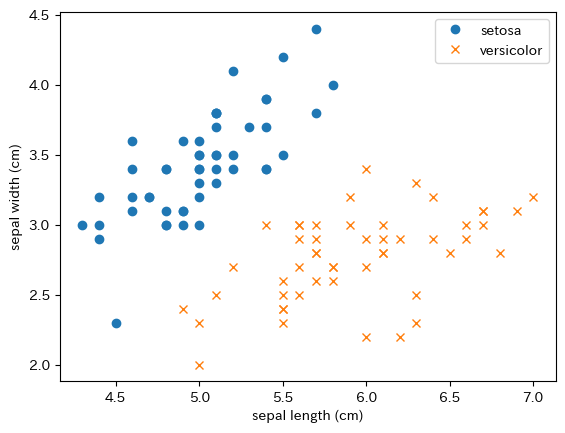

In [5]:
# 今回は2値分類を行うので、'virginica'は除外する。また、入力データは2次元配列にするため、'sepal length (cm)'と'sepal width (cm)'の2列のみを使用する。
df_x = df_x_org[df_iris['iris name'] != 'virginica'][['sepal length (cm)','sepal width (cm)']]
df_y = df_y_org[df_iris['iris name'] != 'virginica']
display_custom(df_x)
display_custom(df_y)
plt.plot(df_x[df_y['iris kind'] == 0]['sepal length (cm)'], df_x[df_y['iris kind'] == 0]['sepal width (cm)'], 'o', label='setosa')
plt.plot(df_x[df_y['iris kind'] == 1]['sepal length (cm)'], df_x[df_y['iris kind'] == 1]['sepal width (cm)'], 'x', label='versicolor')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.show()


In [6]:
# データを訓練用とテスト用に分割する。
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=123)
display_custom(df_x_train,df_x_test,df_y_train,df_y_test)

変数名 :  df_x_train  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),sepal width (cm)
21,5.1,3.7
90,5.5,2.6
33,5.5,4.2
69,5.6,2.5
84,5.4,3.0


形状は (70, 2)
変数名 :  df_x_test  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),sepal width (cm)
8,4.4,2.9
70,5.9,3.2
82,5.8,2.7
28,5.2,3.4
63,6.1,2.9


形状は (30, 2)
変数名 :  df_y_train  変数型は  <class 'pandas.core.frame.DataFrame'>


,iris kind
21,0
90,1
33,0
69,1
84,1


形状は (70, 1)
変数名 :  df_y_test  変数型は  <class 'pandas.core.frame.DataFrame'>


,iris kind
8,0
70,1
82,1
28,0
63,1


形状は (30, 1)


In [7]:
# データをテンソルに変換するためにnumpy配列に変換する。
np_x_train = df_x_train.values
np_x_test = df_x_test.values
np_y_train = df_y_train.values
np_y_test = df_y_test.values

# データをテンソルに変換する。
t_x_train = torch.tensor(np_x_train).float()
t_x_test = torch.tensor(np_x_test).float()
t_y_train = torch.tensor(np_y_train).float()
t_y_test = torch.tensor(np_y_test).float()


In [8]:
# モデルの定義
# 2入力1出力のロジスティクス回帰モデルを定義する。
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.li = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # 重みの初期化
        
        self.li.weight.data.fill_(1.0)
        self.li.bias.data.fill_(1.0)

    #予測関数の定義
    def forward(self, x):
        x = self.li(x)
        x = self.sigmoid(x)
        return x

In [9]:
# 入力データの次元数を取得する。
inputs = t_x_train
input_size = t_x_train.shape[1]
# 出力データの次元数を取得する。
output_size = t_y_train.shape[1]
label = t_y_train
print("入力データの次元数は",input_size)
print("出力データの次元数は",output_size)

入力データの次元数は 2
出力データの次元数は 1


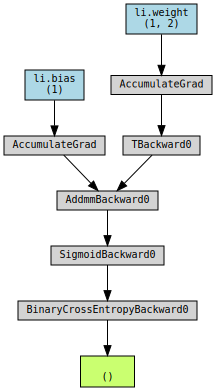

In [10]:
# モデルのインスタンスを作成する。
net = Net(input_size, output_size)

# 計算グラフの可視化してみる。
# モデルの構造を確認する。
outputs =  net(inputs)

loss = nn.BCELoss()(outputs, label)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [11]:
# 学習率
lr = 0.01
# エポック数
epochs = 10000
# モデルのインスタンスを作成する。
net = Net(input_size, output_size)
# 損失関数の定義
criterion = nn.BCELoss()
# 最適化手法の定義
optimizer = optim.SGD(net.parameters(), lr=lr)
#記録用のリストを作成する。
#訓練データの損失と精度、テストデータの損失と精度を記録する。
history = np.zeros((0,5)) #0行5列の行列を作成する。5列は、訓練データの損失、訓練データの精度、テストデータの損失、テストデータの精度、エポック数を表す。

変数名 :  t_y_train  変数型は  <class 'torch.Tensor'>


,0
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


形状は (70, 1)
変数が見つかりませんでした。


,0
0,0
1,0
2,0
3,0
4,0


形状は (70, 1)


In [12]:
# 学習を実行する。
for epoch in range(epochs):
    # 勾配を初期化する。
    optimizer.zero_grad()

    # 順伝播を計算する。
    outputs = net(t_x_train)

    # 損失を計算する。
    loss = criterion(outputs, label)

    # 誤差逆伝播を計算する。
    loss.backward()

    if epoch % 10 == 0:

        # 損失と精度を記録する。
        # まずは訓練データの損失と精度を計算する。
        loss_train = loss.item()
        acc_train = accuracy_score(np_y_train, np.where(outputs.detach().numpy() < 0.5, 0, 1))
        # テストデータの損失と精度を計算する。
        loss_test = criterion(net(t_x_test), t_y_test).item()
        acc_test = accuracy_score(np_y_test, np.where(net(t_x_test).detach().numpy() < 0.5, 0, 1))

        # 記録用のリストに記録する。
        history = np.vstack((history, np.array([epoch, loss_train, acc_train, loss_test, acc_test])))

    # パラメータを更新する。
    optimizer.step()


In [13]:
print(f'初期状態: 損失={history[0,3]:.4f}, 精度={history[0,4]:.4f}')
print(f'最終状態: 損失={history[-1,3]:.4f}, 精度={history[-1,4]:.4f}')

初期状態: 損失=4.5868, 精度=0.5000
最終状態: 損失=0.1540, 精度=0.9667


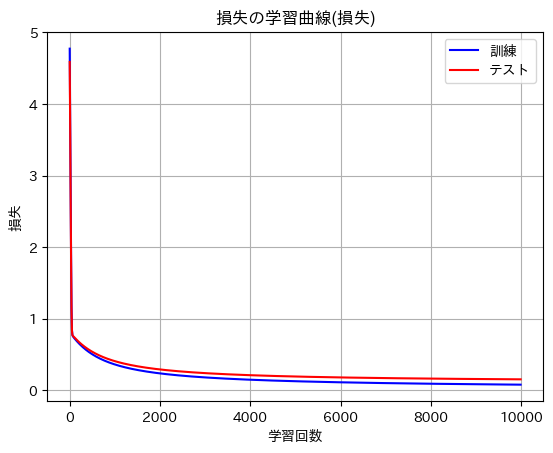

In [14]:
# 学習曲線(損失)を描画する。
plt.plot(history[:,0], history[:,1], 'b',label="訓練")
plt.plot(history[:,0], history[:,3], 'r',label="テスト")
plt.xlabel('学習回数')
plt.ylabel('損失')
plt.title('損失の学習曲線(損失)')
plt.grid(True)
plt.legend()
plt.show()

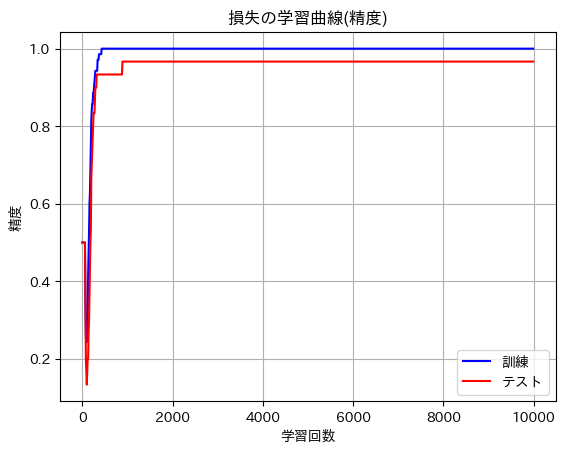

In [15]:
# 学習曲線(精度)を描画する。
plt.plot(history[:,0], history[:,2], 'b',label="訓練")
plt.plot(history[:,0], history[:,4], 'r',label="テスト")
plt.xlabel('学習回数')
plt.ylabel('精度')
plt.title('損失の学習曲線(精度)')
plt.grid(True)
plt.legend()
plt.show()
